In [38]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2

import scdeepaa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import torch

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [40]:
meth = pd.read_csv("../example_data/to_deepAA/Methylation_MOFA_example.csv.gz", delimiter=",", index_col=0)
RNA_expr = pd.read_csv("../example_data/to_deepAA/mRNA_MOFA_example.csv.gz", delimiter=",", index_col=0)
drugs = pd.read_csv("../example_data/to_deepAA/Drugs_MOFA_example.csv.gz", delimiter=",", index_col=0)
muts = pd.read_csv("../example_data/to_deepAA/Mutations_MOFA_example.csv.gz", delimiter=",", index_col=0)

In [41]:
metadata = pd.read_table("ftp://ftp.ebi.ac.uk/pub/databases/mofa/cll_vignette/sample_metadata.txt")

In [42]:
metadata

,sample,Gender,age,TTT,TTD,treatedAfter,died,IGHV,trisomy12
0,H005,m,75.265753,0.574949,2.625599,True,False,1.0,0.0
1,H006,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H007,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H008,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H010,f,72.780822,2.932238,2.932238,False,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...
195,H266,m,74.315068,0.002738,0.903491,True,False,1.0,NaN
196,H268,m,82.539726,0.076660,0.577687,True,False,NaN,0.0
197,H270,f,66.947945,0.216290,0.903491,True,False,1.0,0.0
198,H271,m,65.380822,0.859685,0.859685,False,False,1.0,0.0


In [43]:
meth_np = meth.values.astype(float).T
RNA_np = RNA_expr.values.astype(float).T
drugs_np = drugs.values.astype(float).T
muts_np = muts.values.astype(float).T

In [44]:
dataset_list = [RNA_np, meth_np, drugs_np,muts_np]

In [45]:
norm_factors = [np.ones(dataset.shape[0]) for dataset in  dataset_list]

In [46]:
norm_factors[0].shape

(200,)

In [47]:
input_matrix = [torch.tensor(input_matrix_i) for input_matrix_i in dataset_list]

In [48]:
[torch.tensor(input_matrix_i).float().dtype for input_matrix_i in dataset_list]

[torch.float32, torch.float32, torch.float32, torch.float32]

In [57]:
res = scdeepaa.fit_deepAA(
    dataset_list,
    norm_factors,
    ["G", "G", "G", "B"],
    hidden_dims_dec_common = [128,256],
    hidden_dims_dec_last = [512],
    hidden_dims_enc_ind = [512],
    hidden_dims_enc_common = [256,256],
    hidden_dims_enc_pre_Z = [128, 64],
    lr = 0.01,
    gamma_lr = 0.01,
    steps = 1000,
    narchetypes = 3,
    CUDA = True,
    fix_Z = True)

ELBO: 1208757632.00000  :   0%|          | 2/1000 [00:00<00:49, 19.99it/s]

Fitting full model!


ELBO: 262695632.00000  : 100%|██████████| 1000/1000 [00:18<00:00, 54.64it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


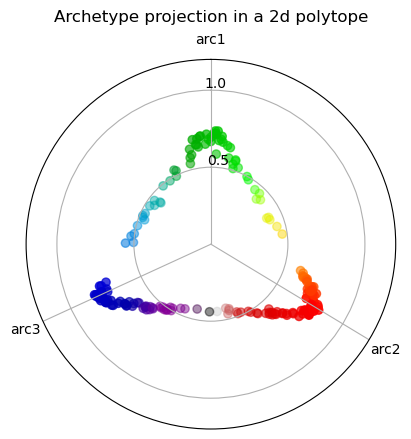

In [58]:
scdeepaa.plot_archetypes_simplex(res)

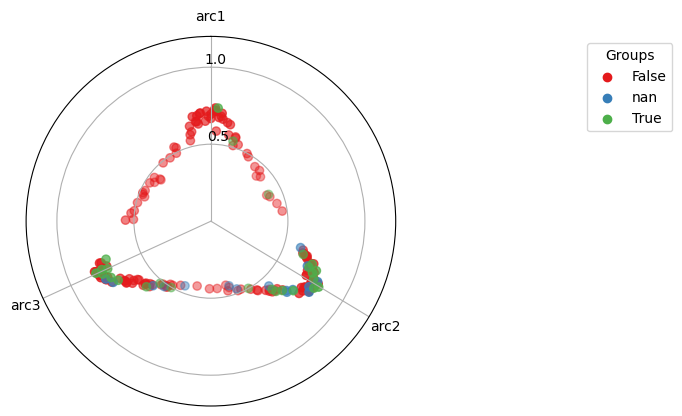

In [59]:
scdeepaa.plot_archetypes_simplex(res, color_by = metadata["died"].astype(str), cmap = "Set1")

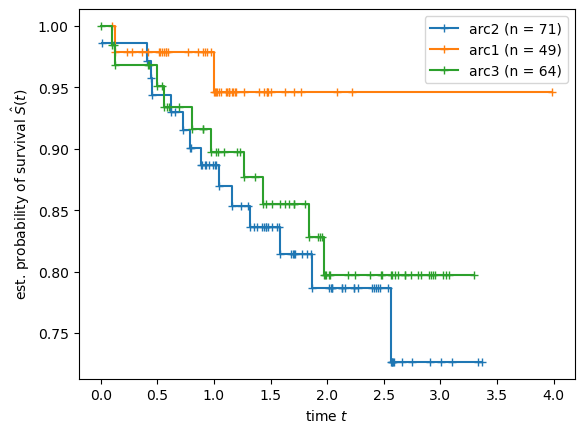

In [60]:
from sksurv.nonparametric import kaplan_meier_estimator


no_nan = metadata["TTD"].notnull().values

for value in set(res["inferred_quantities"]["highest_archetype"]):
    mask = [k == value  for k in np.array(res["inferred_quantities"]["highest_archetype"])[no_nan] ]
    time_cell, survival_prob_cell = kaplan_meier_estimator(metadata["died"][no_nan].values[mask].astype(bool),
                                                           metadata["TTD"][no_nan].values[mask])
    plt.step(time_cell, survival_prob_cell, "-+", where="post",
             label="%s (n = %d)" % (value, np.array(mask).sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")



In [61]:
max_value = 200
batch_size = 1200
ret = torch.randperm(torch.tensor(max_value).item())
rest = max_value % batch_size
N_splits = max_value // batch_size
ret_list = [ret[(i * batch_size):((i+1) * batch_size)] for i in range(N_splits)]
if rest > 0:
    ret_list.append(ret[-rest:])

In [62]:
[rr.shape for rr in ret_list]

[torch.Size([200])]

In [63]:
res["inferred_quantities"]["Z_loss_unreg"]

array(3128458.5, dtype=float32)

In [64]:
res["inferred_quantities"]["input_loss_unreg"]

[array(-8.3776576e+08, dtype=float32),
 array(-4.118161e+08, dtype=float32),
 array(-132056.45, dtype=float32),
 array(-4126.874, dtype=float32)]